In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
import itertools
from scipy import linalg
import matplotlib as mpl
%matplotlib inline

In [125]:
df = pd.read_csv("./Data/Wholesale customers data.csv")

In [126]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [127]:
df.describe()
# Channel has 2 categories
# Region has 3 categories

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [128]:
sc = StandardScaler()
df_z_scaled = df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]
df_z_scaled = sc.fit_transform(df_z_scaled)

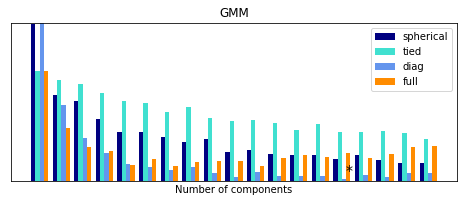

In [158]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(df_z_scaled)
        bic.append(gmm.bic(df_z_scaled))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.xticks(())
plt.yticks(())
plt.title('GMM')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

gmm_final = mixture.GaussianMixture(n_components=15,
                                      covariance_type="diag")



In [130]:
gmm.fit(df_z_scaled)
groups = gmm.predict(df_z_scaled)

In [131]:
print(groups)

[17 17 15  5  3 17  7 17 17 17 15 13  7  7  7  0 17  7  7 17  7 13  3 11
  7  7 13 13 15  3  7  0  0  3  0 17  3 17 17  3  3  7 17  4 17 15  4 16
 17  1  5 17  3 17 13 17  1 17  0 17 17 16 15 17  5  1 17  7 15  0  5 12
  5  5 17 13  5  1 13 17  0 17 17 13  7 14  6 12  5  3 13  5  1 18 17 17
 17  0  0  5 17 17 17 18  0 13 17 17 17  4 13 17  5  5 13 13  0 17 13  5
 13  0 13 17  3  3  5  7 17  3  5  0  0  0  0  0 15 17  7  0  7  7  3  5
  5  1  0  0 13 13 13 17 13 17  0  4 15  0 17 17 17  5 13  4 17  1 15 17
  0 13 17 15 17  4 13 17  3  7 17 15  7 10 17  2 13 17  5 15 17 17  5  0
  0  4 13  5 18 17 13  0  1  4  7  0 13  4  0 15 17  4  5  1  5 17 17 17
  1 13 15 13 13 17  5  5 13  0  7  0 15  5  5 17 13 17  5 17 13  5  0  3
  5 13 13  7 17  4  0 13  5  5  0  1  5  7 15 13 17 15  3  3  5 13 13 15
 17 15  4  3  1 13 13 17 17  3 17  0  3  5  5  7  0 17  3  5  3  3  0  5
  0  3 17  0  5 17 13 17 13 17 17  0  7  4 17  4  4 17  4  0 13 15  5  3
  4 13 13 15 13 17  5  1  0 13  0  7  5  8 13  0  5

In [132]:
groups = pd.Series(groups)
groups.value_counts().sort_values(ascending=False)

17    98
0     65
13    65
5     61
7     37
3     30
15    26
4     24
1     17
18     6
12     2
16     2
2      1
8      1
10     1
6      1
11     1
14     1
9      1
dtype: int64

In [133]:
df["gmm"] = groups  

<AxesSubplot:>

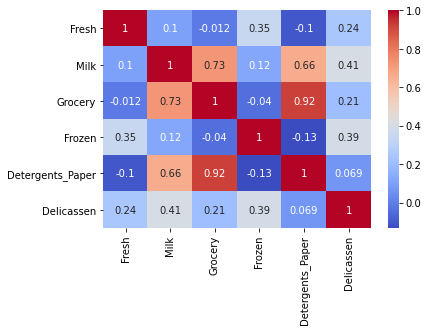

In [134]:
sns.heatmap(df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].corr(), cmap="coolwarm", annot=True)
# Grocery is correlated with Milk and Detergents_Paper

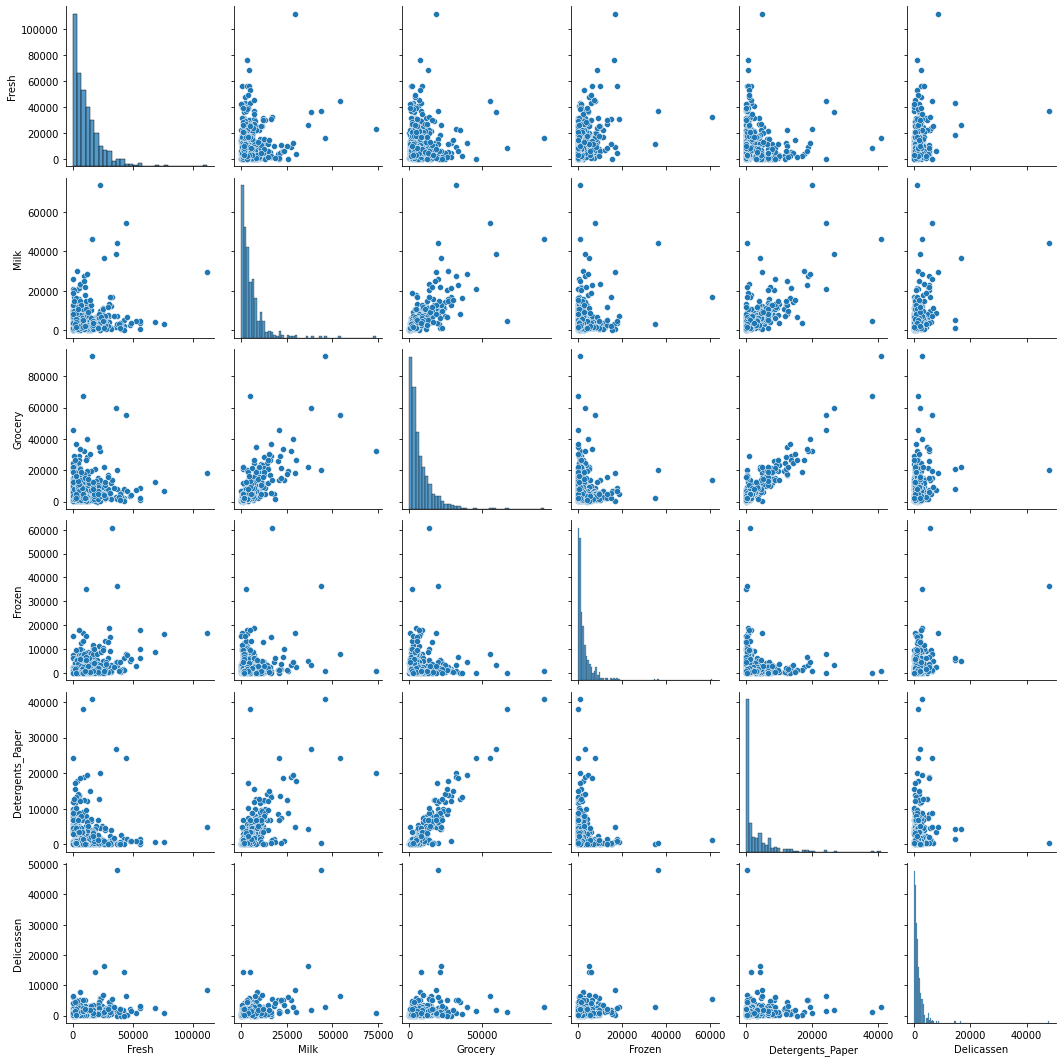

In [135]:
sns.pairplot(df[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]])

<AxesSubplot:xlabel='Grocery', ylabel='Detergents_Paper'>

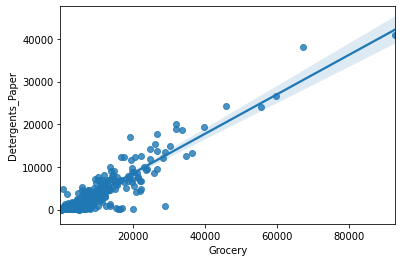

In [136]:
sns.regplot(x="Grocery", y="Detergents_Paper", data=df[["Grocery", "Detergents_Paper"]])

<AxesSubplot:xlabel='Grocery', ylabel='Milk'>

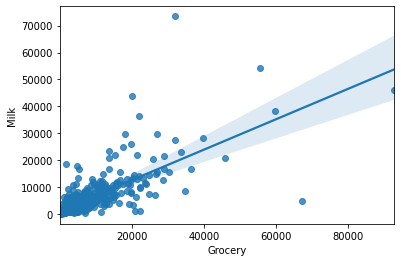

In [137]:
sns.regplot(x="Grocery", y="Milk", data=df[["Grocery", "Milk"]])

In [138]:
df11 = df[(df["Channel"] == 1) & (df["Region"] == 1)]
df12 = df[(df["Channel"] == 1) & (df["Region"] == 2)]
df13 = df[(df["Channel"] == 1) & (df["Region"] == 3)]
df21 = df[(df["Channel"] == 2) & (df["Region"] == 1)]
df22 = df[(df["Channel"] == 2) & (df["Region"] == 2)]
df23 = df[(df["Channel"] == 2) & (df["Region"] == 3)]

In [139]:
dfs = [df11, df12, df13, df21, df22, df23]
types = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]
for kind in types:
    print("------------------------")
    print(kind)    
    print("------------------------")
    for df in dfs:
        print("Mean", df[kind].mean().round())
    for df in dfs:
        print("Var", df[kind].var().round())
    for df in dfs:
        print("SD", df[kind].std().round())

------------------------
Fresh
------------------------
Mean 12902.0
Mean 11651.0
Mean 13878.0
Mean 5200.0
Mean 7290.0
Mean 9832.0
Var 152325184.0
Var 80449468.0
Var 217461413.0
Var 29327873.0
Var 47168525.0
Var 92840820.0
SD 12342.0
SD 8969.0
SD 14747.0
SD 5416.0
SD 6868.0
SD 9635.0
------------------------
Milk
------------------------
Mean 3870.0
Mean 2304.0
Mean 3487.0
Mean 10784.0
Mean 9191.0
Mean 10981.0
Var 18475565.0
Var 8812756.0
Var 20326620.0
Var 43681808.0
Var 43710004.0
Var 111826970.0
SD 4298.0
SD 2969.0
SD 4509.0
SD 6609.0
SD 6611.0
SD 10575.0
------------------------
Grocery
------------------------
Mean 4026.0
Mean 4396.0
Mean 3887.0
Mean 18472.0
Mean 16326.0
Mean 15954.0
Var 13174317.0
Var 9292126.0
Var 12913286.0
Var 108465723.0
Var 196993963.0
Var 151263811.0
SD 3630.0
SD 3048.0
SD 3594.0
SD 10415.0
SD 14035.0
SD 12299.0
------------------------
Frozen
------------------------
Mean 3127.0
Mean 5745.0
Mean 3657.0
Mean 2584.0
Mean 1541.0
Mean 1513.0
Var 10735191.0
Var

In [140]:
#Observations: 
# Channel 1 Region 3 is the largest region (211 total rows)
# Channel 2 Region 3 is next largest (105 total rows)
#Channel 1, Region 1 is next largest (59 total rows)
#Channel 1, Region 2 is next, (28 total rows)
#The rest have less than 20 rows each

In [142]:
df13["gmm"].value_counts().sort_values(ascending=False)

0     51
5     38
13    37
17    32
3     22
7     14
15     6
18     5
12     2
1      1
2      1
4      1
10     1
Name: gmm, dtype: int64

In [143]:
df13[df13["gmm"]==10]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,gmm
181,1,3,112151,29627,18148,16745,4948,8550,10


In [144]:
df13[df13["gmm"]==4]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,gmm
430,1,3,3097,4230,16483,575,241,2080,4


In [145]:
df13[df13["gmm"]==2]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,gmm
183,1,3,36847,43950,20170,36534,239,47943,2


In [146]:
df13[df13["gmm"]==1]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,gmm
426,1,3,13134,9347,14316,3141,5079,1894,1


In [147]:
df13[df13["gmm"]==12]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,gmm
71,1,3,18291,1266,21042,5373,4173,14472,12
87,1,3,43265,5025,8117,6312,1579,14351,12


In [154]:
df13.groupby(["gmm"])[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].agg(["mean", "std", "var"])

Fresh                                      Milk               \
              mean           std           var          mean          std   
gmm                                                                         
0      7191.450980   5588.531096  3.123168e+07   1694.078431  1113.590012   
1     13134.000000           NaN           NaN   9347.000000          NaN   
2     36847.000000           NaN           NaN  43950.000000          NaN   
3     40054.409091  13290.690855  1.766425e+08   3404.909091  2102.090341   
4      3097.000000           NaN           NaN   4230.000000          NaN   
5     12892.052632   6667.492162  4.445545e+07   2880.000000  1775.015782   
7     14031.214286   8046.563559  6.474719e+07   5530.142857  3084.635494   
10   112151.000000           NaN           NaN  29627.000000          NaN   
12    30778.000000  17659.284753  3.118503e+08   3145.500000  2658.014390   
13    13681.189189   8175.322440  6.683590e+07   1133.513514   431.104951   
15     4018.000000   3496.302618  1.222413e+07  11541.833333  6943.557429   
17     3243.187500   2841.264183  8.072782e+06   4461.187500  2216.323903   
18    26618.800000  19995.233149  3.998093e+08   8038.200000  6042.666440   

                        Grocery                                   Frozen  \
              var          mean          std           var          mean   
gmm                                                                        
0    1.240083e+06   1896.294118  1005.485381  1.011001e+06   1137.960784   
1             NaN  14316.000000          NaN           NaN   3141.000000   
2             NaN  20170.000000          NaN           NaN  36534.000000   
3    4.418784e+06   4706.545455  3031.258229  9.188526e+06   4977.500000   
4             NaN  16483.000000          NaN           NaN    575.000000   
5    3.150681e+06   2679.342105  1394.355616  1.944228e+06   7159.526316   
7    9.514976e+06   5484.785714  2662.399386  7.088370e+06   1081.214286   
10            NaN  18148.000000          NaN           NaN  16745.000000   
12   7.065040e+06  14579.500000  9139.355147  8.352781e+07   5842.500000   
13   1.858515e+05   2252.918919  1234.046041  1.522870e+06   2598.405405   
15   4.821299e+07   6733.666667  5213.246768  2.717794e+07   5156.666667   
17   4.912092e+06   5629.718750  3247.280115  1.054483e+07    687.031250   
18   3.651382e+07   7811.400000  5215.704392  2.720357e+07  19824.000000   

                               Detergents_Paper                             \
             std           var             mean          std           var   
gmm                                                                          
0     765.113010  5.853979e+05       432.764706   384.020082  1.474714e+05   
1            NaN           NaN      5079.000000          NaN           NaN   
2            NaN           NaN       239.000000          NaN           NaN   
3    3997.938633  1.598351e+07       670.227273   617.613065  3.814459e+05   
4            NaN           NaN       241.000000          NaN           NaN   
5    3899.901778  1.520923e+07       522.710526   397.192234  1.577617e+05   
7     778.171049  6.055502e+05      1077.071429   928.782285  8.626365e+05   
10           NaN           NaN      4948.000000          NaN           NaN   
12    663.973268  4.408605e+05      2876.000000  1834.234990  3.364418e+06   
13   1352.898380  1.830334e+06       237.351351   183.589399  3.370507e+04   
15   1075.022728  1.155674e+06      1297.500000  1335.196278  1.782749e+06   
17    570.282187  3.252218e+05      1822.562500  1831.729606  3.355233e+06   
18   8730.304834  7.621822e+07       616.800000   581.123653  3.377047e+05   

       Delicassen                             
             mean          std           var  
gmm                                           
0      423.000000   260.994789  6.811828e+04  
1     1894.000000          NaN           NaN  
2    47943.000000          NaN           NaN  
3     1927.863636  1588.239735  

In [155]:
df23.groupby(["gmm"])[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].agg(["mean", "std", "var"])

Fresh                                      Milk                \
             mean           std           var          mean           std   
gmm                                                                         
0    17565.000000           NaN           NaN   3686.000000           NaN   
1    10011.111111   6781.692146  4.599135e+07  17977.888889   7362.112697   
3    34338.333333  10166.063611  1.033488e+08   4423.333333    854.593081   
4     1772.846154   1969.096191  3.877340e+06   9781.000000   4713.685165   
5    19899.000000           NaN           NaN   5332.000000           NaN   
6    22925.000000           NaN           NaN  73498.000000           NaN   
7    19485.812500   5288.589783  2.796918e+07   6296.500000   2580.987537   
11   26373.000000           NaN           NaN  36423.000000           NaN   
13   13146.000000           NaN           NaN   1124.000000           NaN   
14   16117.000000           NaN           NaN  46197.000000           NaN   
15    4191.818182   1980.490688  3.922343e+06  11674.363636   7486.837307   
16   40204.000000   6027.378203  3.632929e+07  46314.000000  11235.926753   
17    5818.444444   4331.043594  1.875794e+07   8060.711111   2772.212512   

                        Grocery                                  Frozen  \
              var          mean          std           var         mean   
gmm                                                                       
0             NaN   4657.000000          NaN           NaN  1059.000000   
1    5.420070e+07  29529.444444  8060.278378  6.496809e+07  1812.111111   
3    7.303293e+05   6009.666667  1127.458351  1.271162e+06  1937.000000   
4    2.221883e+07  22507.230769  3167.269385  1.003160e+07  1024.923077   
5             NaN   8713.000000          NaN           NaN  8132.000000   
6             NaN  32114.000000          NaN           NaN   987.000000   
7    6.661497e+06  10096.375000  3141.399070  9.868388e+06  1335.500000   
11            NaN  22019.000000          NaN           NaN  5154.000000   
13            NaN   4523.000000          NaN           NaN  1420.000000   
14            NaN  92780.000000          NaN           NaN  1026.000000   
15   5.605273e+07  14273.000000  6144.130060  3.775033e+07  2436.000000   
16   1.262460e+08  57584.500000  2847.519008  8.108364e+06  5518.000000   
17   7.685162e+06  11116.488889  3130.942522  9.802801e+06  1032.533333   

                               Detergents_Paper                             \
             std           var             mean          std           var   
gmm                                                                          
0            NaN           NaN      1803.000000          NaN           NaN   
1    1566.983363  2.455437e+06     14324.111111  5401.774302  2.917917e+07   
3    1762.787282  3.107419e+06      1629.000000  1039.928844  1.081452e+06   
4     758.977323  5.760466e+05      9262.153846  3955.467394  1.564572e+07   
5            NaN           NaN       764.000000          NaN           NaN   
6            NaN           NaN     20070.000000          NaN           NaN   
7     944.036581  8.912051e+05      3777.875000  1237.292252  1.530892e+06   
11           NaN           NaN      4337.000000          NaN           NaN   
13           NaN           NaN       549.000000          NaN           NaN   
14           NaN           NaN     40827.000000          NaN           NaN   
15   1704.918004  2.906745e+06      5873.454545  1911.958910  3.655587e+06   
16   3201.779505  1.025139e+07     25436.000000  1788.980156  3.200450e+06   
17    896.537876  8.037802e+05      5020.711111  2050.159446  4.203154e+06   

       Delicassen                             
             mean          std           var  
gmm                                           
0      668.000000          NaN           NaN  
1     2143.777778  1589.892668  2.527759e+06  
3     2899.333333  2036.459264  4.147166e+06  
4      855.692308   925.296023  8.561727e+05  


In [156]:
df11.groupby(["gmm"])[["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]].agg(["mean", "std", "var"])

Fresh                                     Milk                \
             mean           std           var         mean           std   
gmm                                                                        
0     6598.375000   3902.657261  1.523073e+07  1761.000000    995.316174   
3    44418.500000  16084.825592  2.587216e+08  3327.750000   1751.165588   
5    12315.727273   5911.485213  3.494566e+07  2973.000000   1434.665815   
7    21979.666667   9573.994586  9.166137e+07  7674.666667   3963.265110   
13   14491.125000   8703.531903  7.575147e+07  1007.000000    570.683800   
15    5757.000000   3770.904136  1.421972e+07  9024.400000  10892.869815   
17    3463.000000   3071.505820  9.434148e+06  6979.363636   2311.381936   
18   30624.000000           NaN           NaN  7209.000000           NaN   

                        Grocery                                   Frozen  \
              var          mean          std           var          mean   
gmm                                                                        
0    9.906543e+05   1894.875000  1069.663690  1.144180e+06   1179.000000   
3    3.066581e+06   3953.750000  2360.531914  5.572111e+06   4663.000000   
5    2.058266e+06   2877.454545  1770.311914  3.134004e+06   4787.090909   
7    1.570747e+07  10525.000000  5990.932398  3.589127e+07   2019.333333   
13   3.256800e+05   2344.312500  1704.520058  2.905389e+06   2646.875000   
15   1.186546e+08   5517.200000  5161.331098  2.663934e+07   5023.800000   
17   5.342486e+06   6668.090909  4178.930017  1.746346e+07   1048.363636   
18            NaN   4897.000000          NaN           NaN  18711.000000   

                               Detergents_Paper                             \
             std           var             mean          std           var   
gmm                                                                          
0     675.011746  4.556409e+05       425.500000   292.621647  8.562743e+04   
3    1486.564944  2.209875e+06       815.500000   110.424937  1.219367e+04   
5    3544.048940  1.256028e+07       417.727273   278.908978  7.779022e+04   
7    2638.413223  6.961224e+06       776.333333   785.324349  6.167343e+05   
13   1659.529004  2.754037e+06       237.437500   199.535116  3.981426e+04   
15   3298.836189  1.088232e+07      2725.200000  1574.012611  2.477516e+06   
17    509.872783  2.599703e+05      2209.363636  1972.730457  3.891665e+06   
18           NaN           NaN       763.000000          NaN           NaN   

      Delicassen                             
            mean          std           var  
gmm                                          
0     457.625000   278.251139  7.742370e+04  
3    2505.000000  1269.705740  1.612153e+06  
5    1334.181818   853.165027  7.278906e+05  
7    3547.666667  2907.299835  8.452392e+06  
13    617.562500   369.281278  1.363687e+05  
15   1700.400000  1628.513064  2.652055e+06  
17    943.000000   770.395353  5.935090e+05  
18   2876.000000          NaN           NaN